**Machine Learning Demo**

This is a first step towards using Machine Learning in solving linear problems more efficiently. It leverages on existing code from my Bachelors thesis.



In [1]:
# Imports
import copy
import matplotlib.pyplot as plt

%pip install imageio

# Importing the supportive functions from additional files
from Utilities.input_gen_utils import *  # Input generation
from Utilities.format_utils import *     # Formatting values for prettier printing

# The implementation of Simplex algrithm with counts.
from simplex_with_counts import *
from simplex import *

# Mainly used for visualizing input distributions as a pixel matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**Experiment A**

Adding random levels of sparsity to validate correctness.

Starting experiment for sparsity rate: 0.5% (random)
Finished experiment for sparsity rate: 0.5% (random)
Starting experiment for sparsity rate: 0.5% (linear)
Finished experiment for sparsity rate: 0.5% (linear)
Starting experiment for sparsity rate: 0.5% (gaussian)
Finished experiment for sparsity rate: 0.5% (gaussian)
Starting experiment for sparsity rate: 1.0% (random)
Finished experiment for sparsity rate: 1.0% (random)
Starting experiment for sparsity rate: 1.0% (linear)
Finished experiment for sparsity rate: 1.0% (linear)
Starting experiment for sparsity rate: 1.0% (gaussian)
Finished experiment for sparsity rate: 1.0% (gaussian)
Starting experiment for sparsity rate: 1.5% (random)
Finished experiment for sparsity rate: 1.5% (random)
Starting experiment for sparsity rate: 1.5% (linear)
Finished experiment for sparsity rate: 1.5% (linear)
Starting experiment for sparsity rate: 1.5% (gaussian)
Finished experiment for sparsity rate: 1.5% (gaussian)
Starting experiment for sparsity r

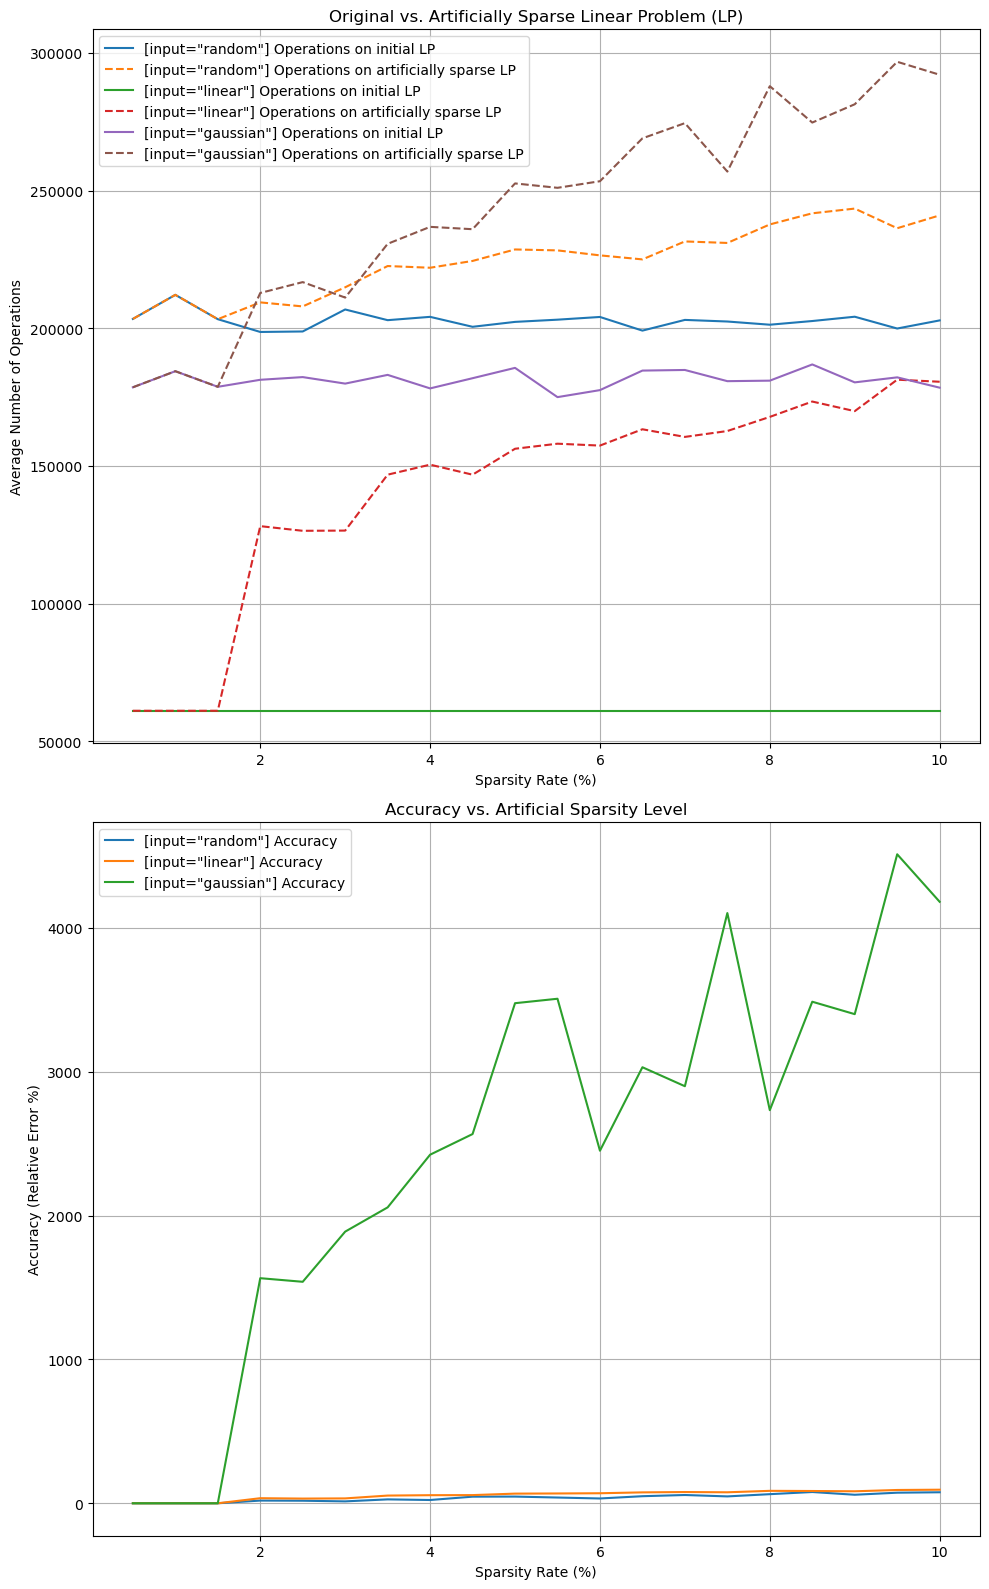

In [8]:
import matplotlib.pyplot as plt

# Setup for input generation and experiment parameters
input_generation_functions = {
    'random': generate_random_simplex_input,
    # 'geometric': generate_varied_geometric_simplex_input,
    'linear': generate_linear_simplex_input,
    # 'symmetric': generate_symmetric_simplex_input,
    'gaussian': generate_gaussian_simplex_input,
}

# Dictionaries to store average operations and accuracy measurements for both dense and sparse solutions
avg_ops_initial_dense = {input_type: [] for input_type in input_generation_functions}
avg_ops_artificial_sparse = {input_type: [] for input_type in input_generation_functions}
accuracy_measurements = {input_type: [] for input_type in input_generation_functions}
sparsity_levels = [0.005 * i for i in range(1, 21)]  # 1% to 10% sparsity
num_constraints = []

# Experiment parameters
constraints_n, variables_n = 64, 64  # This is constant across all runs
number_of_runs_for_iteration = 600
min_value, max_value = 1, 10000

# Main experiment loop
for sparsity_rate in sparsity_levels:
    for input_type, gen_func in input_generation_functions.items():
        ops_total_initial_dense = []
        ops_total_artificial_sparse = []
        accuracy_scores = []
        print(f"Starting experiment for sparsity rate: {sparsity_rate * 100}% ({input_type})")

        for i in range(number_of_runs_for_iteration):
            A_base, b_base, c_base = gen_func(constraints_n, variables_n, min_value, max_value)

            A_1, b_1, c_1 = copy.deepcopy(A_base), copy.deepcopy(b_base), copy.deepcopy(c_base)
            A_2, b_2, c_2 = copy.deepcopy(A_base), copy.deepcopy(b_base), copy.deepcopy(c_base)

            
            # Solving the initial dense matrices
            sol_dense, counts_dense = simplex_w_counts(A_1, b_1, c_1, func='max', matrix='sparse')
            solution_dense = sol_dense[-1][-1]
            ops_total_initial_dense.append(sum(counts_dense.values()))

            # Introduce sparsity and solve
            b_sparse, c_sparse = make_sparse_simplex_input(b_2, c_2, sparsity=sparsity_rate)
            sol_sparse, counts_sparse = simplex_w_counts(A_2, b_sparse, c_sparse, func='max', matrix='sparse')
            solution_sparse = sol_sparse[-1][-1]
            ops_total_artificial_sparse.append(sum(counts_sparse.values()))

            # Measure accuracy (relative error percentage)
            accuracy = abs(solution_dense - solution_sparse) / abs(solution_dense) * 100  # Result in percentage
            accuracy_scores.append(accuracy)
            
            # More logging for large experiments so we can somewhat see the progress still...
            if (i + 1) % (number_of_runs_for_iteration / 5) == 0:
                # print(f"{i + 1}/{number_of_runs_for_iteration} runs completed for: SPARSITY {sparsity_rate * 100}% ({input_type})")
                pass

        # Store average results for this sparsity level
        avg_ops_initial_dense[input_type].append(sum(ops_total_initial_dense) / len(ops_total_initial_dense))
        avg_ops_artificial_sparse[input_type].append(sum(ops_total_artificial_sparse) / len(ops_total_artificial_sparse))
        accuracy_measurements[input_type].append(sum(accuracy_scores) / len(accuracy_scores))
        print(f"Finished experiment for sparsity rate: {sparsity_rate * 100}% ({input_type})")

    num_constraints.append(sparsity_rate * 100)  # Store sparsity level as a percentage

plt.figure(figsize=(10, 16))
for input_type in avg_ops_initial_dense:
    plt.subplot(2, 1, 1)
    plt.plot(num_constraints, avg_ops_initial_dense[input_type], label=f'[input="{input_type}"] Operations on initial LP')
    plt.plot(num_constraints, avg_ops_artificial_sparse[input_type], label=f'[input="{input_type}"] Operations on artificially sparse LP', linestyle='--')
    plt.xlabel('Sparsity Rate (%)')
    plt.ylabel('Average Number of Operations')
    plt.title('Original vs. Artificially Sparse Linear Problem (LP)')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(num_constraints, accuracy_measurements[input_type], label=f'[input="{input_type}"] Accuracy')
    plt.xlabel('Sparsity Rate (%)')
    plt.ylabel('Accuracy (Relative Error %)')
    plt.title('Accuracy vs. Artificial Sparsity Level')
    plt.legend(loc='upper left')
    plt.grid(True)

plt.tight_layout()
plt.show()


The experiment shows, that for small levels of introduced sparsity the effect on accuracy is neglible, but we don't measure any performance gains.

For larger levels of artificially introduced sparsity, we immediately start to see the loss of accuracy (even if considered against a "not-so-good" metric). This holds for different input distributions (random, linear, geometric, gaussian and symmetric).

This enforces the belief, that by altering the original LP by removing constraints we are unable to get an accurate answer.

However, a way to look at it could be through geometry, since all the consyraints together form a polyhedron. A machine learning model might be able to construct a "similar" one which uses far less constraints. I believe that the best LP solvers already do so, by finding out which regions are not near the estimated solution at all and cutting them off immediately.

---

🌼 If you're wondering why the "sparse" matrcies need more operations than "dense" ones, although the Simplex Method knows how to exploit the sparse matrices, then you'll need to know that by adding random sparsity we might make some LPs harder (or impossible) to solve. This adds complexity. Also, the way my implementation solves the LPs is by setting elements in the pivot columns to zeroes after it has been used; this also makes the dense inputs perform better.